## Exp_2_compare_CBR_domain
Compare CBR Systems' performance with and without domain knowledge ('Matched' attribute)

Experiments:
    
    1- Performance evaluation of CBR system without domain knowledge 
    
    2- Performance evaluation of CBR system with domain knowledge 


In [1]:
# import required packages
import pandas as pd
import numpy as np

import shap
import joblib
import dice_ml

import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support, classification_report, confusion_matrix, plot_confusion_matrix

#from pandas import json_normalize
import warnings
import requests
from requests import get
import time

from mycbr_py_api import MyCBRRestApi as mycbr

In [2]:
warnings.filterwarnings("ignore")

# Variables that are related to current CBR project
concept = 'case' 

# To list all concept names in the project uncomment the following line
# print(obj.getAllConcepts())

In [3]:
# API connection

server = 'localhost'
#server = 'user@hv-6066.idi.ntnu.no'

port = '8080'
base_url = 'http://' + server + ':' + port + '/'

headers = {'Content-type':'application/json'}

obj = mycbr(base_url)

In [4]:
# Read data 
train = pd.read_csv('./data/train.csv') # _oversampled.csv')
test = pd.read_csv('./data/test.csv')

train_X, train_y = train.drop(['Target'],axis=1), train['Target']

In [5]:
# Compare expected answers with query values
def rowExpFlip(row, exp):
    lst = []
    for i in range(len(row)):
        if bool(row.iloc[i]) == exp.iloc[i]['Value']:
            lst.append(1)
        else:
            lst.append(0)
    return lst


# Calculate 'Matched' value for a query
def calculateMatched(row):
    comp_list = rowExpFlip(row, expected_answers.T)
    comp_df =  pd.DataFrame(comp_list).T
    comp_df.columns = col_list
  
    return sum(comp_list)

# Deletes all cases from specified concept 
def delete_instances_from_concept(c):
    response = requests.delete('http://localhost:8080/concepts/'+c+'/cases')
    print("cases deleted from " + c + ": " + str(response.ok))
    
# Adds a new casebase 
def put_new_cb(newCbName):
    requests.put(base_url + 'casebases/' + newCbName)
    
# Returns casebase list
def get_casebases():
    raw = pd.DataFrame(requests.get(base_url + 'casebases/').json())
    casebases = pd.DataFrame.from_records(raw).values.tolist()
    return casebases

# add cases to casebase
def add_rows_as_cases(x, c, cb):
    case_id = 'case_' + str(x['index'])
    x = x.drop(['Target', 'index'])
    requests.put(base_url + 'concepts/' + c + '/casebases/' + cb +'/cases/' + case_id, data = str(x.to_json()), headers=headers)

# add cases to casebase from dataframe
def add_cases_from_df(df, c, cb):  
    tmp = df.copy(deep=True)
    tmp.reset_index(inplace=True)
    tmp.apply(add_rows_as_cases, args=(c, cb), axis=1)
    
# Rename indices of shap values (like 't0, t1')    
def rename_indices(idx):
    indx = []
    for i in range(len(idx)-1,-1,-1):
        indx.append('t'+str(idx[i]))
    return indx

# Add new amalgamation function
def newAmalgamationFunc(c, amalFuncID, amalFuncType, json):
    return requests.put(base_url + 'concepts/' + c + '/amalgamationFunctions?amalgamationFunctionID=' + amalFuncID + '&amalgamationFunctionType=' + amalFuncType + '&attributeWeightsJSON=' + json)

# Retrieves similar cases from given casebase
def query_cbr_system(concept, casebase, amalgamationFct, queryJSON, k=-1):
    #print(obj.getAllCasesFromCaseBase(concept, casebase).shape)
    raw = requests.post(base_url + 'concepts/' + concept + '/casebases/' + casebase + '/amalgamationFunctions/' + amalgamationFct +'/retrievalByMultipleAttributes?k='+ str(k), 
                        data=str(queryJSON),
                        headers = headers)
    results = pd.DataFrame.from_dict(raw.json())
    results = results.apply(pd.to_numeric, errors='coerce').fillna(results).sort_values(by='similarity', ascending=False)
    return results[['caseID', 'similarity']]


# Returns a dataframe of similar cases from all casebases
def query_all_cbr_systems(concept, query, k):
    class_0_cbr_results = query_cbr_system(concept, 'cb_class0', 'amal_func_class0', query.to_json(), k)
    if 1 in class_0_cbr_results.similarity.values:
        class_0_cbr_results = query_cbr_system(concept, 'cb_class0', 'amal_func_class0', query.to_json(), k+1)    
        class_0_cbr_results = class_0_cbr_results[1:].reset_index(drop=True)
    class_0_cbr_results.columns = ['caseID_c0', 'similarity_c0']
    
    class_1_cbr_results = query_cbr_system(concept, 'cb_class1', 'amal_func_class1', query.to_json(), k)
    if 1 in class_1_cbr_results.similarity.values:
        class_1_cbr_results = query_cbr_system(concept, 'cb_class1', 'amal_func_class1', query.to_json(), k+1)    
        class_1_cbr_results = class_1_cbr_results[1:].reset_index(drop=True)
    class_1_cbr_results.columns = ['caseID_c1', 'similarity_c1']
    
    class_2_cbr_results = query_cbr_system(concept, 'cb_class2', 'amal_func_class2', query.to_json(), k)
    if 1 in class_2_cbr_results.similarity.values:
        class_2_cbr_results = query_cbr_system(concept, 'cb_class2', 'amal_func_class2', query.to_json(), k+1)    
        class_2_cbr_results = class_2_cbr_results[1:].reset_index(drop=True)
    class_2_cbr_results.columns = ['caseID_c2', 'similarity_c2']
    
    return pd.concat([class_0_cbr_results, class_1_cbr_results, class_2_cbr_results], axis=1)

# Returns class information of most similar case 
def get_class_from_cbr_results(x):
    classid = 5
    class_list = [x.similarity_c0, x.similarity_c1, x.similarity_c2]
    classid =class_list.index(max(class_list))
    return classid

### 1- CBR system without 'Matched' attribute
Before adding the domain knowledge to the system

In [6]:
# Delete all cases
delete_instances_from_concept(concept)

print('Casebase names: ', get_casebases())

# Please uncomment following 3 lines if you don't see 'cb_class0', 'cb_class1', and 'cb_class2' in the list
# put_new_cb('cb_class0')
# put_new_cb('cb_class1')
# put_new_cb('cb_class2')

cases deleted from case: True
Case base names:  [['cb_class1'], ['cb_class0'], ['cb_class2']]


In [7]:
# Group test samples up to classes
train_class0 = train.loc[train.Target == 0]
train_class1 = train.loc[train.Target == 1]
train_class2 = train.loc[train.Target == 2]

# Adding cases to respective casebases
add_cases_from_df(train_class0, concept, 'cb_class0')    
add_cases_from_df(train_class1, concept, 'cb_class1')    
add_cases_from_df(train_class2, concept, 'cb_class2')    

In [8]:
# Viewing the cases in a given casebase
obj.getAllCasesFromCaseBase(concept, 'cb_class0').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class1').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class2').head()

,similarity,caseID,Matched,t0,t1,t10,t100,t101,t11,t12,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
0,1.0,case_36,NaN,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
1,1.0,case_58,NaN,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
2,1.0,case_37,NaN,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1
3,1.0,case_34,NaN,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,1
4,1.0,case_78,NaN,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1


In [9]:
# Read shap values to create amalgamation functuions
shap_c0 = pd.read_csv('./shap_values/c0.csv', index_col=[0]) #_os.csv', index_col=[0])
shap_c1 = pd.read_csv('./shap_values/c1.csv', index_col=[0]) #_os.csv', index_col=[0])
shap_c2 = pd.read_csv('./shap_values/c2.csv', index_col=[0]) #_os.csv', index_col=[0])

In [10]:
matched_booster = 0
shap_c0 = shap_c0.append(pd.DataFrame({'shap':0},index=['Matched']))
shap_c1 = shap_c1.append(pd.DataFrame({'shap':0},index=['Matched']))
shap_c2 = shap_c2.append(pd.DataFrame({'shap':0},index=['Matched']))

In [11]:
# Cast shap values to string for creating json objects (for newAmalgamationFunc)
str_map0 = str(shap_c0.to_dict()['shap']).replace("'",'"')
str_map1 = str(shap_c1.to_dict()['shap']).replace("'",'"')
str_map2 = str(shap_c2.to_dict()['shap']).replace("'",'"')

In [12]:
# Set amalgamation functions for each casebase
newAmalgamationFunc('case','amal_func_class0', 'WEIGHTED_SUM', str_map0)
newAmalgamationFunc('case','amal_func_class1', 'WEIGHTED_SUM', str_map1)
newAmalgamationFunc('case','amal_func_class2', 'WEIGHTED_SUM', str_map2)

<Response [200]>

In [13]:
# Query test samples from CBR system and create a df to compare CBR results with ground truth
test_data = test.reset_index()
test_data.head()

test_df = pd.DataFrame()

for case_idx in range(len(test_data)):
    query_c = test_data.loc[case_idx]
    target = query_c.Target
    query_c = query_c.drop(labels=['Target']).drop(['index'])

    result_df = query_all_cbr_systems(concept,  query_c, k=1)
    result_df['Class'] = target
  
    test_df = test_df.append(result_df)

test_df['cbr_class'] = test_df.apply(get_class_from_cbr_results, axis=1)

              precision    recall  f1-score   support

           0       0.27      0.50      0.35         6
           1       0.33      0.60      0.43         5
           2       0.00      0.00      0.00        10

    accuracy                           0.29        21
   macro avg       0.20      0.37      0.26        21
weighted avg       0.16      0.29      0.20        21



<AxesSubplot:>

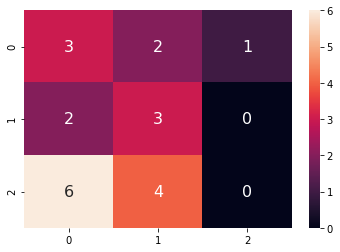

In [14]:
# Print evaluation results
y_pred = test_df['cbr_class']
y_true = test_df['Class']

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={"size": 16})

### 2- CBR system with 'Matched' attribute
After adding the domain knowledge to the system

In [15]:
# Exploring expected answers (domain knowledge)
expected_answers = pd.read_csv('./expectedanswers.txt', sep = '\\*\\*')
expected_answers.columns = ['Question', 'Value']

expected_answers.head()

,Question,Value
0,1. Most of the time I have difficulty concentr...,True
1,2. I don't feel like doing my daily chores,True
2,3. My friends or family have told me that I lo...,True
3,4. When I think about the future it is hard fo...,True
4,5. People around me often ask me how I feel,True


In [16]:
expected_answers = expected_answers.T

expected_answers.columns = ['t' + str(col) for col in expected_answers.columns]

col_list = train_X.columns.to_list()

In [17]:
# Add 'Matched' info to train set
matched = []
for i in range(len(train_X)):
    matched.append(calculateMatched(train_X.iloc[i]))
    
train_X_m = train_X
train_X_m['Matched'] =  matched

train_m = train_X_m.join(train_y)

# Save Train Set + 'Matched' 
train_m.to_csv('./data/train_matched.csv')

In [18]:
train_X_m.head()

,t0,t1,t2,t3,t4,t5,t6,t7,t8,t9,...,t93,t94,t95,t96,t97,t98,t99,t100,t101,Matched
0,1,1,0,1,0,1,1,0,0,1,...,0,1,0,0,1,0,1,1,0,61
1,0,0,1,0,0,1,1,1,0,0,...,0,1,1,0,1,0,1,0,1,44
2,1,1,1,1,0,1,1,0,1,1,...,0,1,0,0,1,0,1,1,1,53
3,0,1,1,1,0,1,0,0,1,1,...,1,1,0,0,1,0,1,1,1,61
4,1,0,1,0,1,1,1,1,0,0,...,0,1,0,0,1,0,1,0,1,42


#### CBR setup

In [19]:
# Delete all cases
delete_instances_from_concept(concept)

print('Casebase names: ', get_casebases())

# Please uncomment following 3 lines if you don't see 'cb_class0', 'cb_class1', and 'cb_class2' in the list
# put_new_cb('cb_class0')
# put_new_cb('cb_class1')
# put_new_cb('cb_class2')

cases deleted from case: True
Case base names:  [['cb_class1'], ['cb_class0'], ['cb_class2']]


In [20]:
# Group test samples up to classes
train_class0 = train_m.loc[train_m.Target == 0]
train_class1 = train_m.loc[train_m.Target == 1]
train_class2 = train_m.loc[train_m.Target == 2]

# Adding cases to respective casebases
add_cases_from_df(train_class0, concept, 'cb_class0')    
add_cases_from_df(train_class1, concept, 'cb_class1')    
add_cases_from_df(train_class2, concept, 'cb_class2')    

In [21]:
# Viewing the cases in a given casebase
obj.getAllCasesFromCaseBase(concept, 'cb_class0').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class1').head()
#obj.getAllCasesFromCaseBase(concept, 'cb_class2').head()

,similarity,caseID,Matched,t0,t1,t10,t100,t101,t11,t12,...,t90,t91,t92,t93,t94,t95,t96,t97,t98,t99
0,1.0,case_36,36,0,0,1,0,1,0,0,...,1,0,0,0,1,0,0,1,0,1
1,1.0,case_58,47,0,0,1,0,1,0,0,...,0,1,0,0,1,0,0,1,0,1
2,1.0,case_37,52,1,0,0,0,0,0,0,...,0,0,0,0,1,1,0,1,0,1
3,1.0,case_34,39,1,0,0,1,0,0,1,...,1,0,0,0,1,0,0,1,0,1
4,1.0,case_78,40,0,0,0,0,1,0,0,...,0,0,0,0,1,0,0,1,0,1


In [22]:
matched_booster = 15
shap_c0_m = shap_c0.append(pd.DataFrame({'shap':shap_c0.max().item()*matched_booster},index=['Matched']))
shap_c1_m = shap_c1.append(pd.DataFrame({'shap':shap_c1.max().item()*matched_booster},index=['Matched']))
shap_c2_m = shap_c2.append(pd.DataFrame({'shap':shap_c2.max().item()*matched_booster},index=['Matched']))

In [23]:
# Cast shap values to string for creating json objects (for newAmalgamationFunc)
str_map0 = str(shap_c0_m.to_dict()['shap']).replace("'",'"')
str_map1 = str(shap_c1_m.to_dict()['shap']).replace("'",'"')
str_map2 = str(shap_c2_m.to_dict()['shap']).replace("'",'"')

In [24]:
# Set amalgamation functions for each casebase
newAmalgamationFunc('case','amal_func_class0', 'WEIGHTED_SUM', str_map0)
newAmalgamationFunc('case','amal_func_class1', 'WEIGHTED_SUM', str_map1)
newAmalgamationFunc('case','amal_func_class2', 'WEIGHTED_SUM', str_map2)

<Response [200]>

In [25]:
# Query test samples from CBR system and create a df to compare CBR results with ground truth
test_data = test.reset_index()
test_data.head()

test_df = pd.DataFrame()

for case_idx in range(len(test_data)):
    query_c = test_data.loc[case_idx]
    target = query_c.Target
    query_c = query_c.drop(labels=['Target']).drop(['index'])
    query_c['Matched'] = calculateMatched(query_c)
    result_df = query_all_cbr_systems(concept,  query_c, k=1)
    result_df['Class'] = target
    test_df = test_df.append(result_df)

test_df['cbr_class'] = test_df.apply(get_class_from_cbr_results, axis=1)

              precision    recall  f1-score   support

           0       0.50      0.83      0.62         6
           1       0.44      0.80      0.57         5
           2       1.00      0.20      0.33        10

    accuracy                           0.52        21
   macro avg       0.65      0.61      0.51        21
weighted avg       0.72      0.52      0.47        21



<AxesSubplot:>

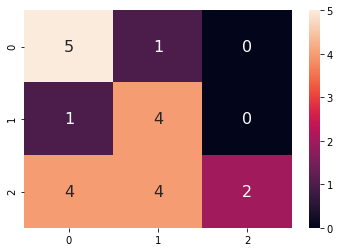

In [26]:
# Print evaluation results
y_pred = test_df['cbr_class']
y_true = test_df['Class']

print(classification_report(y_true, y_pred))

sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, annot_kws={"size": 16})